In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns
import os
import matplotlib.cm as cm
import itertools
import math

In [11]:
# Definitions

embeds = ['InferSent', 'BOW']
classifiers = [ 'LogReg', 'MLP']

id2label = {0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}
label2id = {'CONTRADICTION': 0, 'NEUTRAL':1, 'ENTAILMENT':2}

# Set Scram to true if Analysing performance on ScrambleTests,
# False if on SNLI test set
Scram = True

outpaths = {}
outpaths['TEST_OUT_PATH'] = './regout/'
outpaths['FIG_PATH'] = 'figures/'

outpaths['TEST_DATA_PATH'] = './testData/true/' if Scram else './Downloads/SNLI/true/'
 
# Set toy to true or False for each set
toy = False

if toy:
    outpaths['TEST_DATA_PATH'] = outpaths['TEST_DATA_PATH'].replace('true', 'toy')
    outpaths['TEST_OUT_PATH'] = outpaths['TEST_OUT_PATH'] + 'TOY'
    outpaths['FIG_PATH'] = outpaths['FIG_PATH'] + 'TOY'
    
if Scram:
    tasks = [f[7:] for f in os.listdir(outpaths['TEST_DATA_PATH']) if 'label' in f]
    tasks.sort()
else:
    outpaths['FIG_PATH'] = outpaths['FIG_PATH'] + 'SNLI'
    tasks = ['test']

map_name0 = {'adjr' : 'Adj-Ref bind', 'comp': 'Comparisons', 
            'temp': 'Temporal order', 'subjv': 'Subj-Verb bind',
           'ncon': 'Negate Condition', 'verb': 'Verb Sym', 
            'test': 'SNLI test set', 'dev': 'SNLI dev set'}

map_name = {}

for t in tasks:
    for key, item in map_name0.items():
        if key in t:
            temp = t.replace('_', '--')
            name = temp.replace(key, item)
            map_name[t] = name

In [12]:
def loadresults(name, classifier, tasks, outpaths):
    modelname = name + classifier
    results = {}
    print('\n\n'+'**'*40)
    print("\nLoading tests for {0}...\n".format(modelname))
    print('**'*40 + '\n')
    for task in tasks:
        results[task] = {}
        try:
            results[task]['est'] = np.loadtxt('{0}{1}_labels_{2}'.format(outpaths['TEST_OUT_PATH'], task, modelname), dtype = int)
        except ValueError:
            with open('{0}{1}_labels_{2}'.format(outpaths['TEST_OUT_PATH'], task, modelname)) as f:
                tempor = f.readlines()
                results[task]['est'] = [label2id[x.strip().upper()] for x in tempor]

        results[task]['est_conf'] = np.loadtxt('{0}{1}_confs_{2}'.format(outpaths['TEST_OUT_PATH'], task, modelname))
        try:
            results[task]['true'] = np.loadtxt('{0}labels.{1}'.format(outpaths['TEST_DATA_PATH'], task), dtype = int)
        except ValueError:
            with open('{0}labels.{1}'.format(outpaths['TEST_DATA_PATH'], task)) as f:
                tempor = f.readlines()
                results[task]['true'] = [label2id[x.strip().upper()] for x in tempor]

            
        
        results[task]['est'] = np.array([id2label[x] for x in results[task]['est']])
        results[task]['true'] = np.array([id2label[x] for x in results[task]['true']])
    return results

In [14]:
all_results = {}
for embed in embeds:
    for classifier in classifiers:
        all_results[embed+classifier] = loadresults(embed, classifier, tasks, outpaths)



********************************************************************************

Loading tests for InferSentLogReg...

********************************************************************************



********************************************************************************

Loading tests for InferSentMLP...

********************************************************************************



********************************************************************************

Loading tests for BOWLogReg...

********************************************************************************



********************************************************************************

Loading tests for BOWMLP...

********************************************************************************



In [15]:
def plot_hist(data):
    # Create the bar plot
    ax = sns.countplot(
        x="true",
        hue="est",
        order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
        hue_order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
        data=data)
    return plt.gcf(), ax

In [16]:
N = 1

for classifier in classifiers:
    print('+='*30)
    print('*'*66)
    print ("MAX DIFF classifications for ", classifier)
    print('*'*66)
    print('+='*30)    
\
    for task in tasks:
        with open("{0}s1.{1}".format(outpaths['TEST_DATA_PATH'], task))as f:
            sents_A = f.readlines()
        with open('{0}s2.{1}'.format(outpaths['TEST_DATA_PATH'], task)) as f:
            sents_B = f.readlines()

        tru = np.array(all_results['BOW'+classifier][task]['true'])
        est_B = np.array(all_results['BOW'+classifier][task]['est'])
        est_I = np.array(all_results['InferSent'+classifier][task]['est'])
        filt = np.logical_and(est_B != tru, est_I == tru)
    
        conf_B = np.array([100*all_results['BOW'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(est_B)])
        conf_I = np.array([100*all_results['InferSent'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(est_I)])
        conf_B_intrue = np.array([100*all_results['BOW'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(tru)])
        conf_I_intrue = np.array([100*all_results['InferSent'+classifier][task]['est_conf'][i][label2id[j]] for i, j in enumerate(tru)])
    
        diff_con = conf_I + conf_B
    #     diff_con = conf_B
        order = np.argsort(-diff_con)
    
    
        print('*'*66)
        print("TASK: ", map_name[task])
        print('*'*66, '\n')
        disp = 0
        for disp_i in order:
            if disp < N:
                if filt[disp_i]:
                    print(sents_A[disp_i])
                    print(sents_B[disp_i])
                    print("True: ", tru[disp_i], "\t Estimated BOW: ", est_B[disp_i])
                    print("\nIS conf: ", conf_I[disp_i], "\t BOW conf: ", conf_B[disp_i], "\t BOW conf in true: ", conf_B_intrue[disp_i])
                    print("\n", "-"*40, "\n")

                    disp += 1
   

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
******************************************************************
('MAX DIFF classifications for ', 'LogReg')
******************************************************************
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
******************************************************************
('TASK: ', 'Adj-Ref bind--long')
('******************************************************************', '\n')
The happy man with a beard, shoves the sad waitress with red shoes . 

The man with a beard, shoves the happy waitress with red shoes . 

('True: ', 'CONTRADICTION', '\t Estimated BOW: ', 'ENTAILMENT')
('\nIS conf: ', 91.359734535217285, '\t BOW conf: ', 86.975967884063721, '\t BOW conf in true: ', 0.42111603543162346)
('\n', '----------------------------------------', '\n')
******************************************************************
('TASK: ', 'Adj-Ref bind--short')
('******************************************

The axes of comparison are : MLP/LogReg, long/short, same/notsame, IS/BOW

In [17]:
#acquire and print percentage correct values

allcorrect = []

# for model, mr in all_results.items():
models = ['BOWLogReg', 'BOWMLP', 'InferSentLogReg', 'InferSentMLP']
for model in models:
    mr = all_results[model]
    names = []
    correct = []
    hist = []
    for task, results in mr.items():
        if 'comp' in task:
            temp = task.replace('same_long_not', 'long_same')
            name = temp.replace('same_short_not', 'short_same')

        else:
            name = task.replace('_same', '')
        
        for add in ['_long', '_short']:
            if add in name:
                name = name.replace(add, '')
                name = name + add
        names.append(name)
        correct.append(100*sum(results['est'] == results['true'])/(1.0*len(results['est'])))
       
        
    correct = [x for _,x in sorted(zip(names, correct))]
    names = sorted(names)
    allcorrect.append(np.array(correct))
  

ac = np.array(allcorrect)        
     
print('\t', models, '\n')        
for n,c in zip(names, ac.T): print(n, '\t', c, '\n')

('\t', ['BOWLogReg', 'BOWMLP', 'InferSentLogReg', 'InferSentMLP'], '\n')
('adjr_long', '\t', array([ 39.20833333,  50.        ,  51.90625   ,  51.38541667]), '\n')
('adjr_short', '\t', array([ 49.70833333,  50.        ,  53.25      ,  54.375     ]), '\n')
('adjr_whois_long', '\t', array([ 37.04166667,  49.83333333,  65.8125    ,  64.66666667]), '\n')
('adjr_whois_short', '\t', array([ 49.54166667,  50.        ,  72.0625    ,  72.34375   ]), '\n')
('comp_ml_long', '\t', array([  0.08333333,   7.375     ,  43.10416667,  50.45833333]), '\n')
('comp_ml_short', '\t', array([  4.5       ,  18.79166667,  42.72916667,  49.6875    ]), '\n')
('comp_not_long', '\t', array([  3.14583333,  45.375     ,  42.54166667,  39.47916667]), '\n')
('comp_not_short', '\t', array([ 37.3125    ,  49.97916667,  31.9375    ,  34.95833333]), '\n')
('comp_same_long', '\t', array([ 12.4375    ,  50.        ,  50.        ,  50.79166667]), '\n')
('comp_same_short', '\t', array([ 47.58333333,  50.        ,  66.83333333

In [18]:
# Print Latex code for table:

for i, task in enumerate(tasks):
    if ('_long' in task):
        dispname = map_name[names[i]] if names[i] in map_name else names[i]
        name = names[i].replace('_long', '')
        print('\multirow{2}{*}{\parbox{1.3cm}{',dispname,'}} & long')
        for val in ac.T[i]: print(' & ', val.round(2))
        print('\\\ \n \cline{2-6} \n & short')
        
        s_name = names[i].replace('_long', '_short')
        for val in ac.T[names.index(s_name)]: print(' & ', val.round(2))
        print ('\\\ \n \hline \n \n')
    else:
        dispname = map_name[names[i]] if names[i] in map_name else names[i]
        print('\multicolumn{2}{||c|}{', dispname,'}')
        for val in ac.T[i]: print(' & ', val.round(2))
        print ('\\\ \n \hline \n \n')



('\\multirow{2}{*}{\\parbox{1.3cm}{', 'Adj-Ref bind--long', '}} & long')
(' & ', 39.210000000000001)
(' & ', 50.0)
(' & ', 51.909999999999997)
(' & ', 51.390000000000001)
\\ 
 \cline{2-6} 
 & short
(' & ', 49.710000000000001)
(' & ', 50.0)
(' & ', 53.25)
(' & ', 54.380000000000003)
\\ 
 \hline 
 

('\\multicolumn{2}{||c|}{', 'Adj-Ref bind--short', '}')
(' & ', 49.710000000000001)
(' & ', 50.0)
(' & ', 53.25)
(' & ', 54.380000000000003)
\\ 
 \hline 
 

('\\multirow{2}{*}{\\parbox{1.3cm}{', 'Adj-Ref bind--whois--long', '}} & long')
(' & ', 37.039999999999999)
(' & ', 49.829999999999998)
(' & ', 65.810000000000002)
(' & ', 64.670000000000002)
\\ 
 \cline{2-6} 
 & short
(' & ', 49.539999999999999)
(' & ', 50.0)
(' & ', 72.060000000000002)
(' & ', 72.340000000000003)
\\ 
 \hline 
 

('\\multicolumn{2}{||c|}{', 'Adj-Ref bind--whois--short', '}')
(' & ', 49.539999999999999)
(' & ', 50.0)
(' & ', 72.060000000000002)
(' & ', 72.340000000000003)
\\ 
 \hline 
 

('\\multirow{2}{*}{\\parbox{1.3cm}

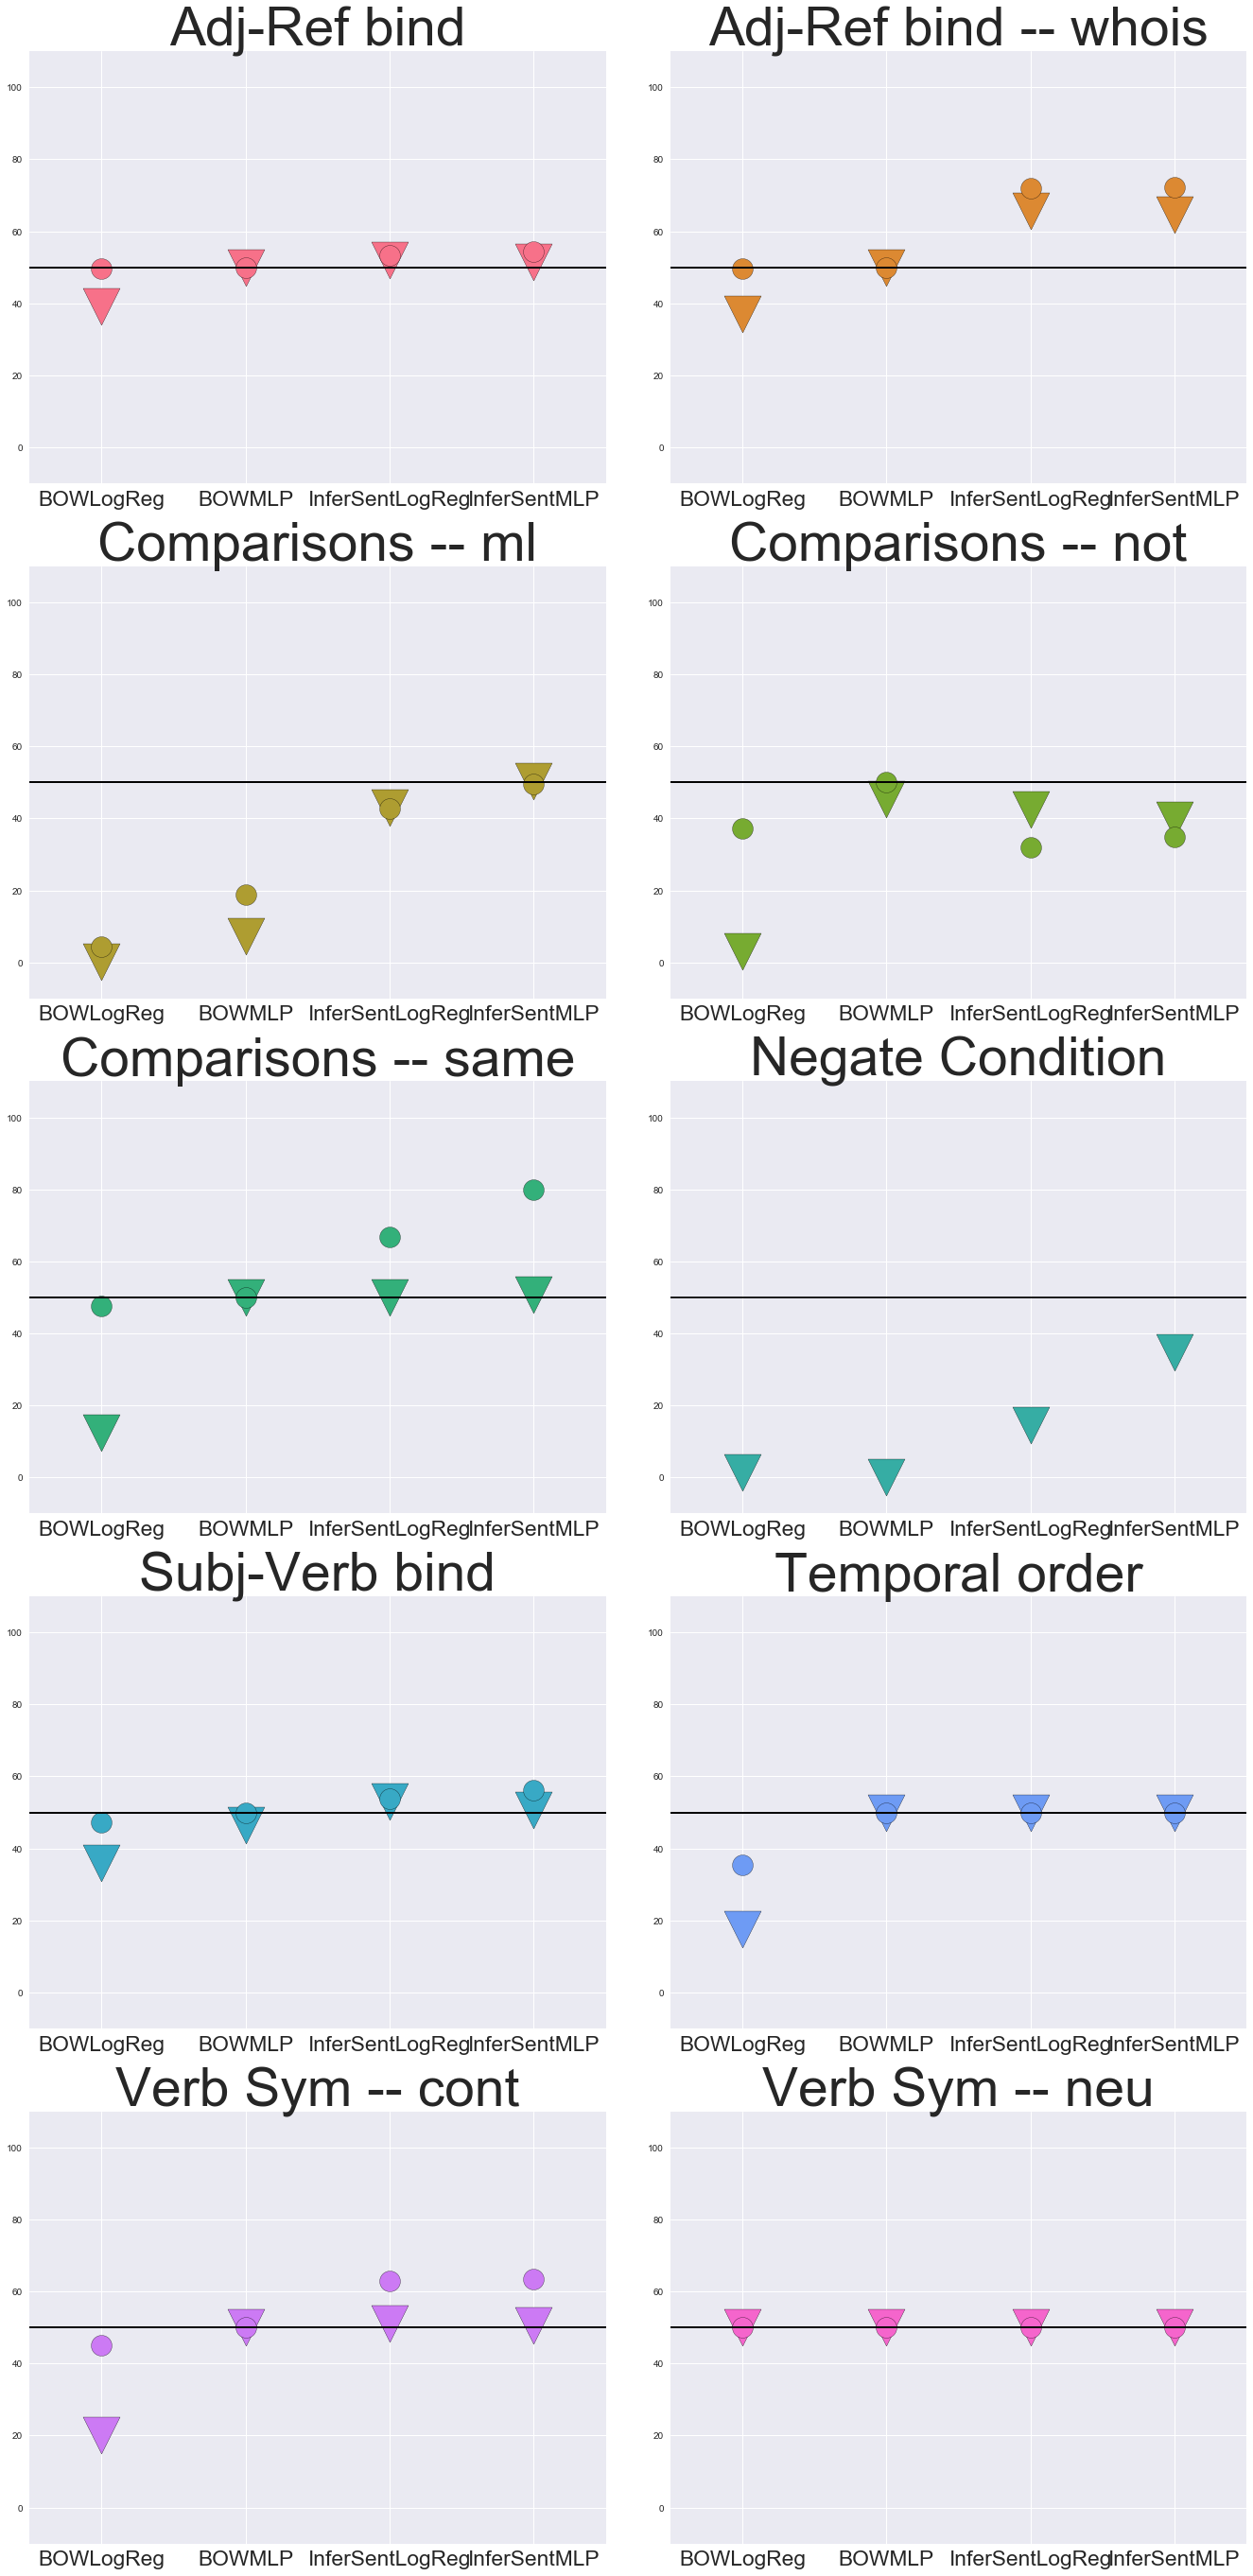

In [19]:
sc = 1.9
fig = plt.figure(figsize=(10*sc,20*sc))
palette = itertools.cycle(sns.color_palette("husl", int(len(ac.T)/2)+1) )
x = np.arange(len(models))
count = 0
for i, vals in enumerate(ac.T):
    if '_short' not in names[i] :
        count += 1
        ax = fig.add_subplot(5,2,count)
        col = next(palette)
        if 'long' in names[i]:
            ax.scatter(x, vals, marker = 'v', label = 'long', edgecolors = 'k', facecolors = col, s = 800*sc)
        else:
            ax.scatter(x, vals, marker = 'v',  facecolors = col, edgecolors = 'k', s = 800*sc)
        
        name = names[i].replace('_long', '')
        name = name.replace("_", " -- ")
        for key in map_name0:
            if key in name:
                name = name.replace(key, map_name0[key])
                
        ax.set_title(name, fontsize = 30*sc)
    else:
        ax.scatter(x, vals, marker = '.', label = 'short', edgecolors = 'k', facecolors = col, s = 1000*sc)
#     ax.legend(frameon=True)
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize = 12*sc)
    ax.set_ylim(0-10,100+10)
    ax.set_xlim(0-0.5,len(models)-0.5)
    ax.hlines(50, xmin = 0-1, xmax = len(models)+1)
plt.tight_layout()
plt.savefig(outpaths['FIG_PATH'] + 'AllTasks')

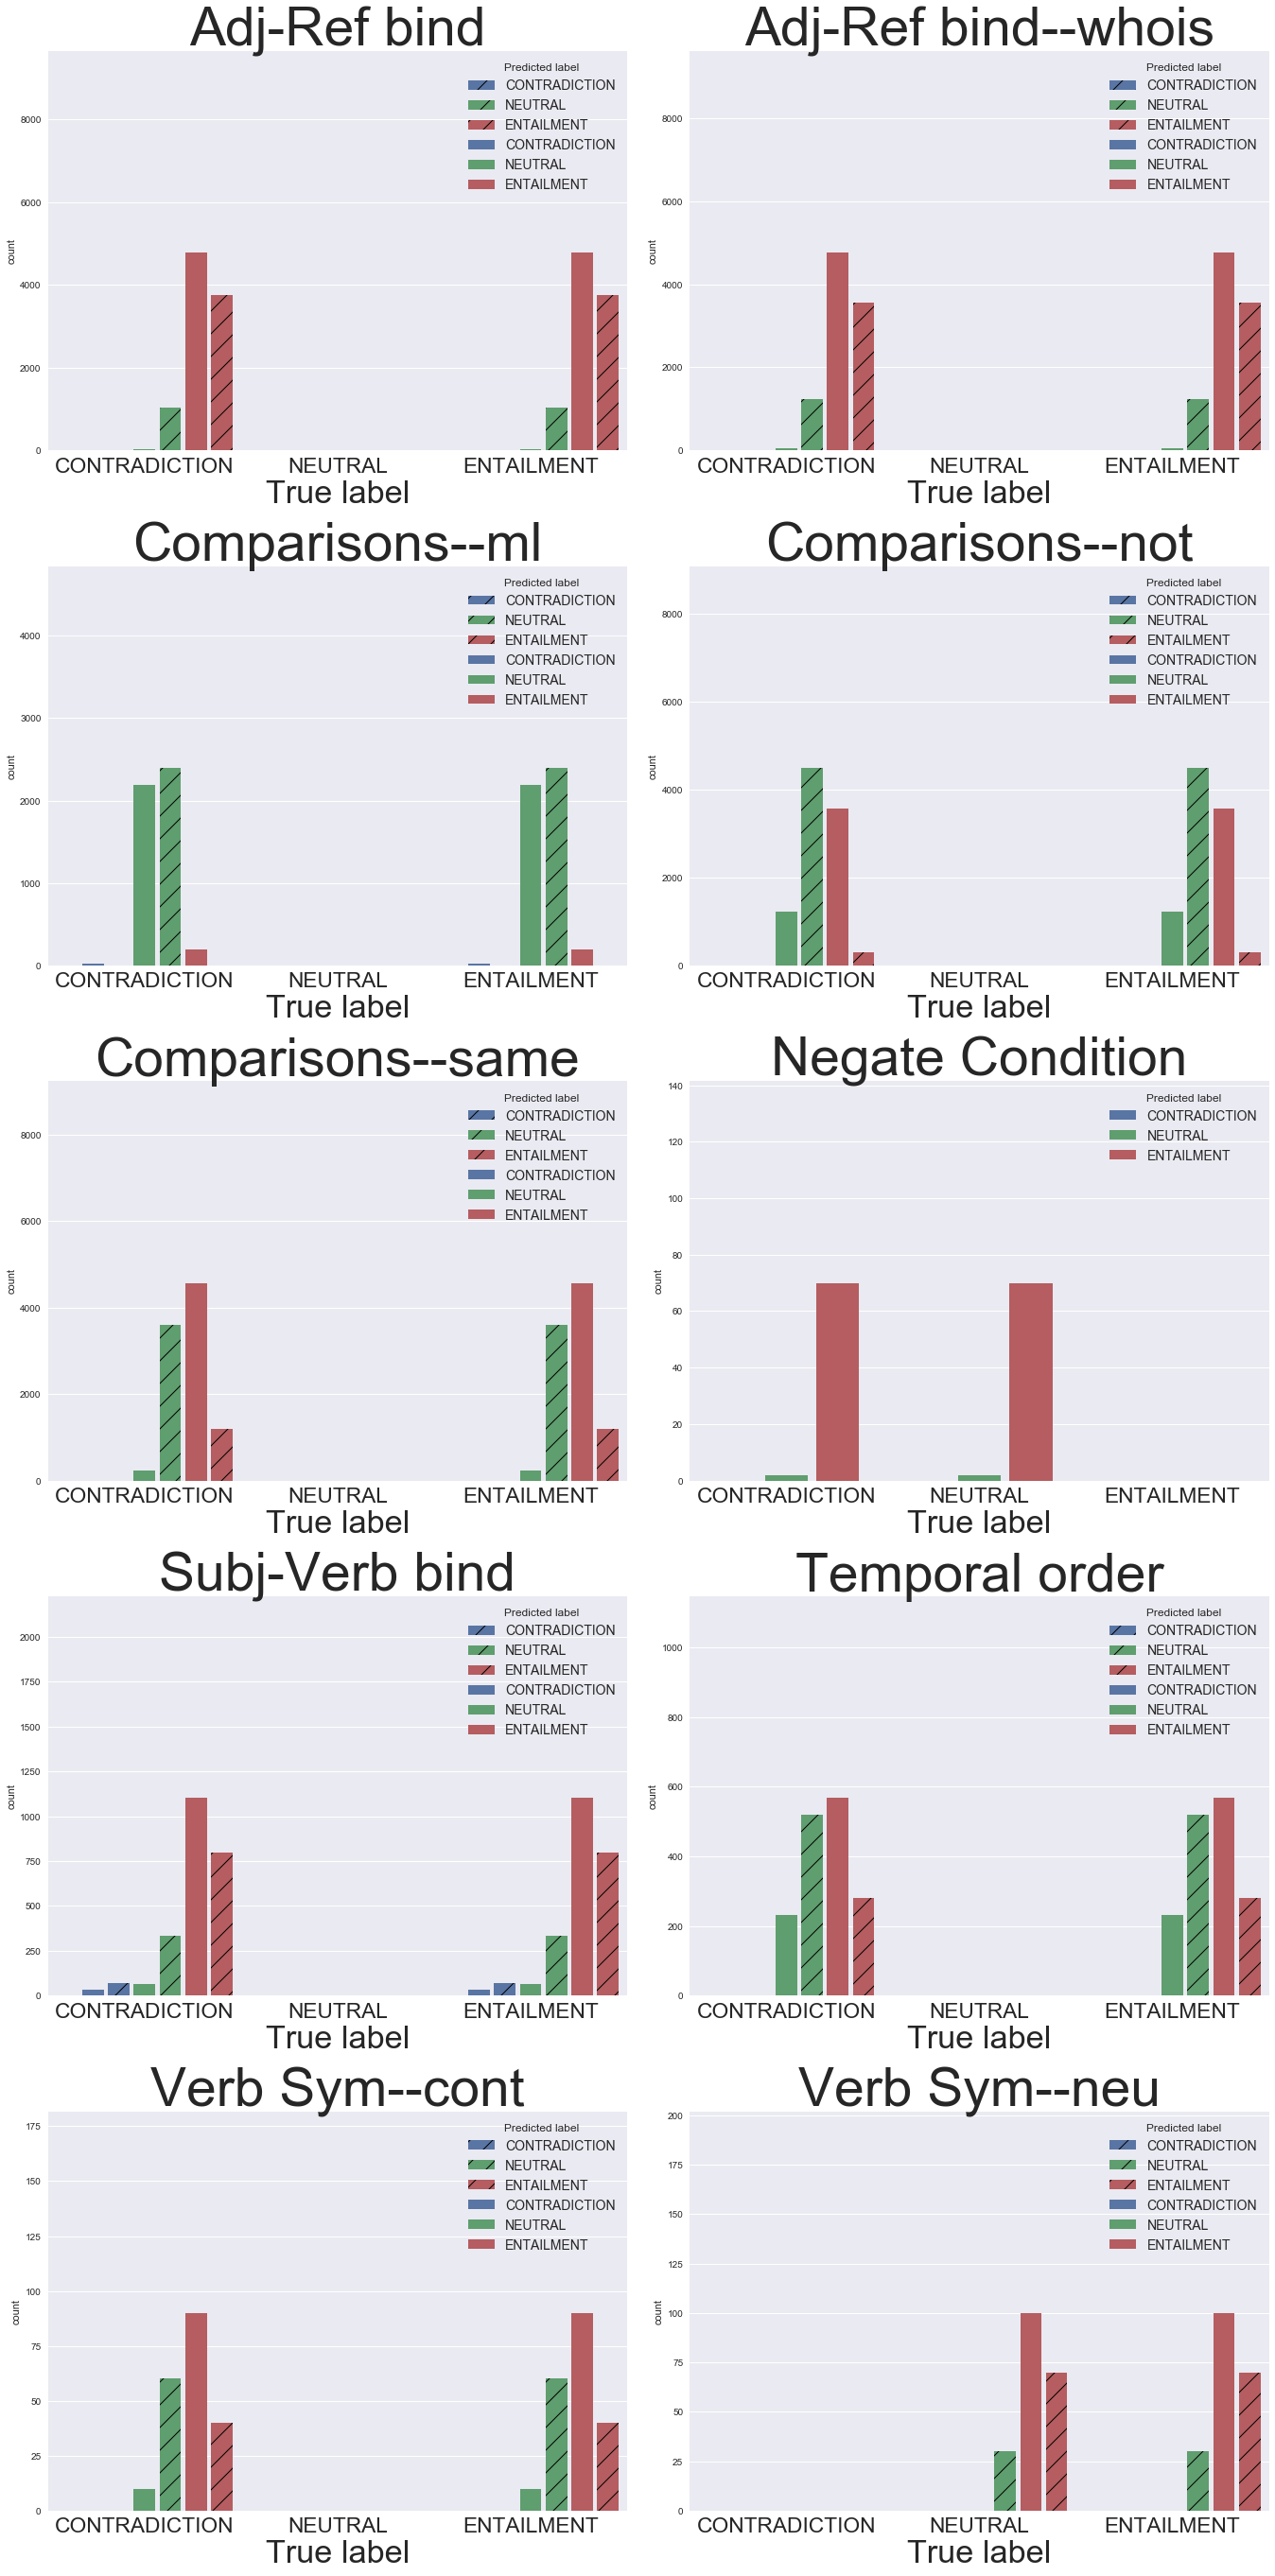

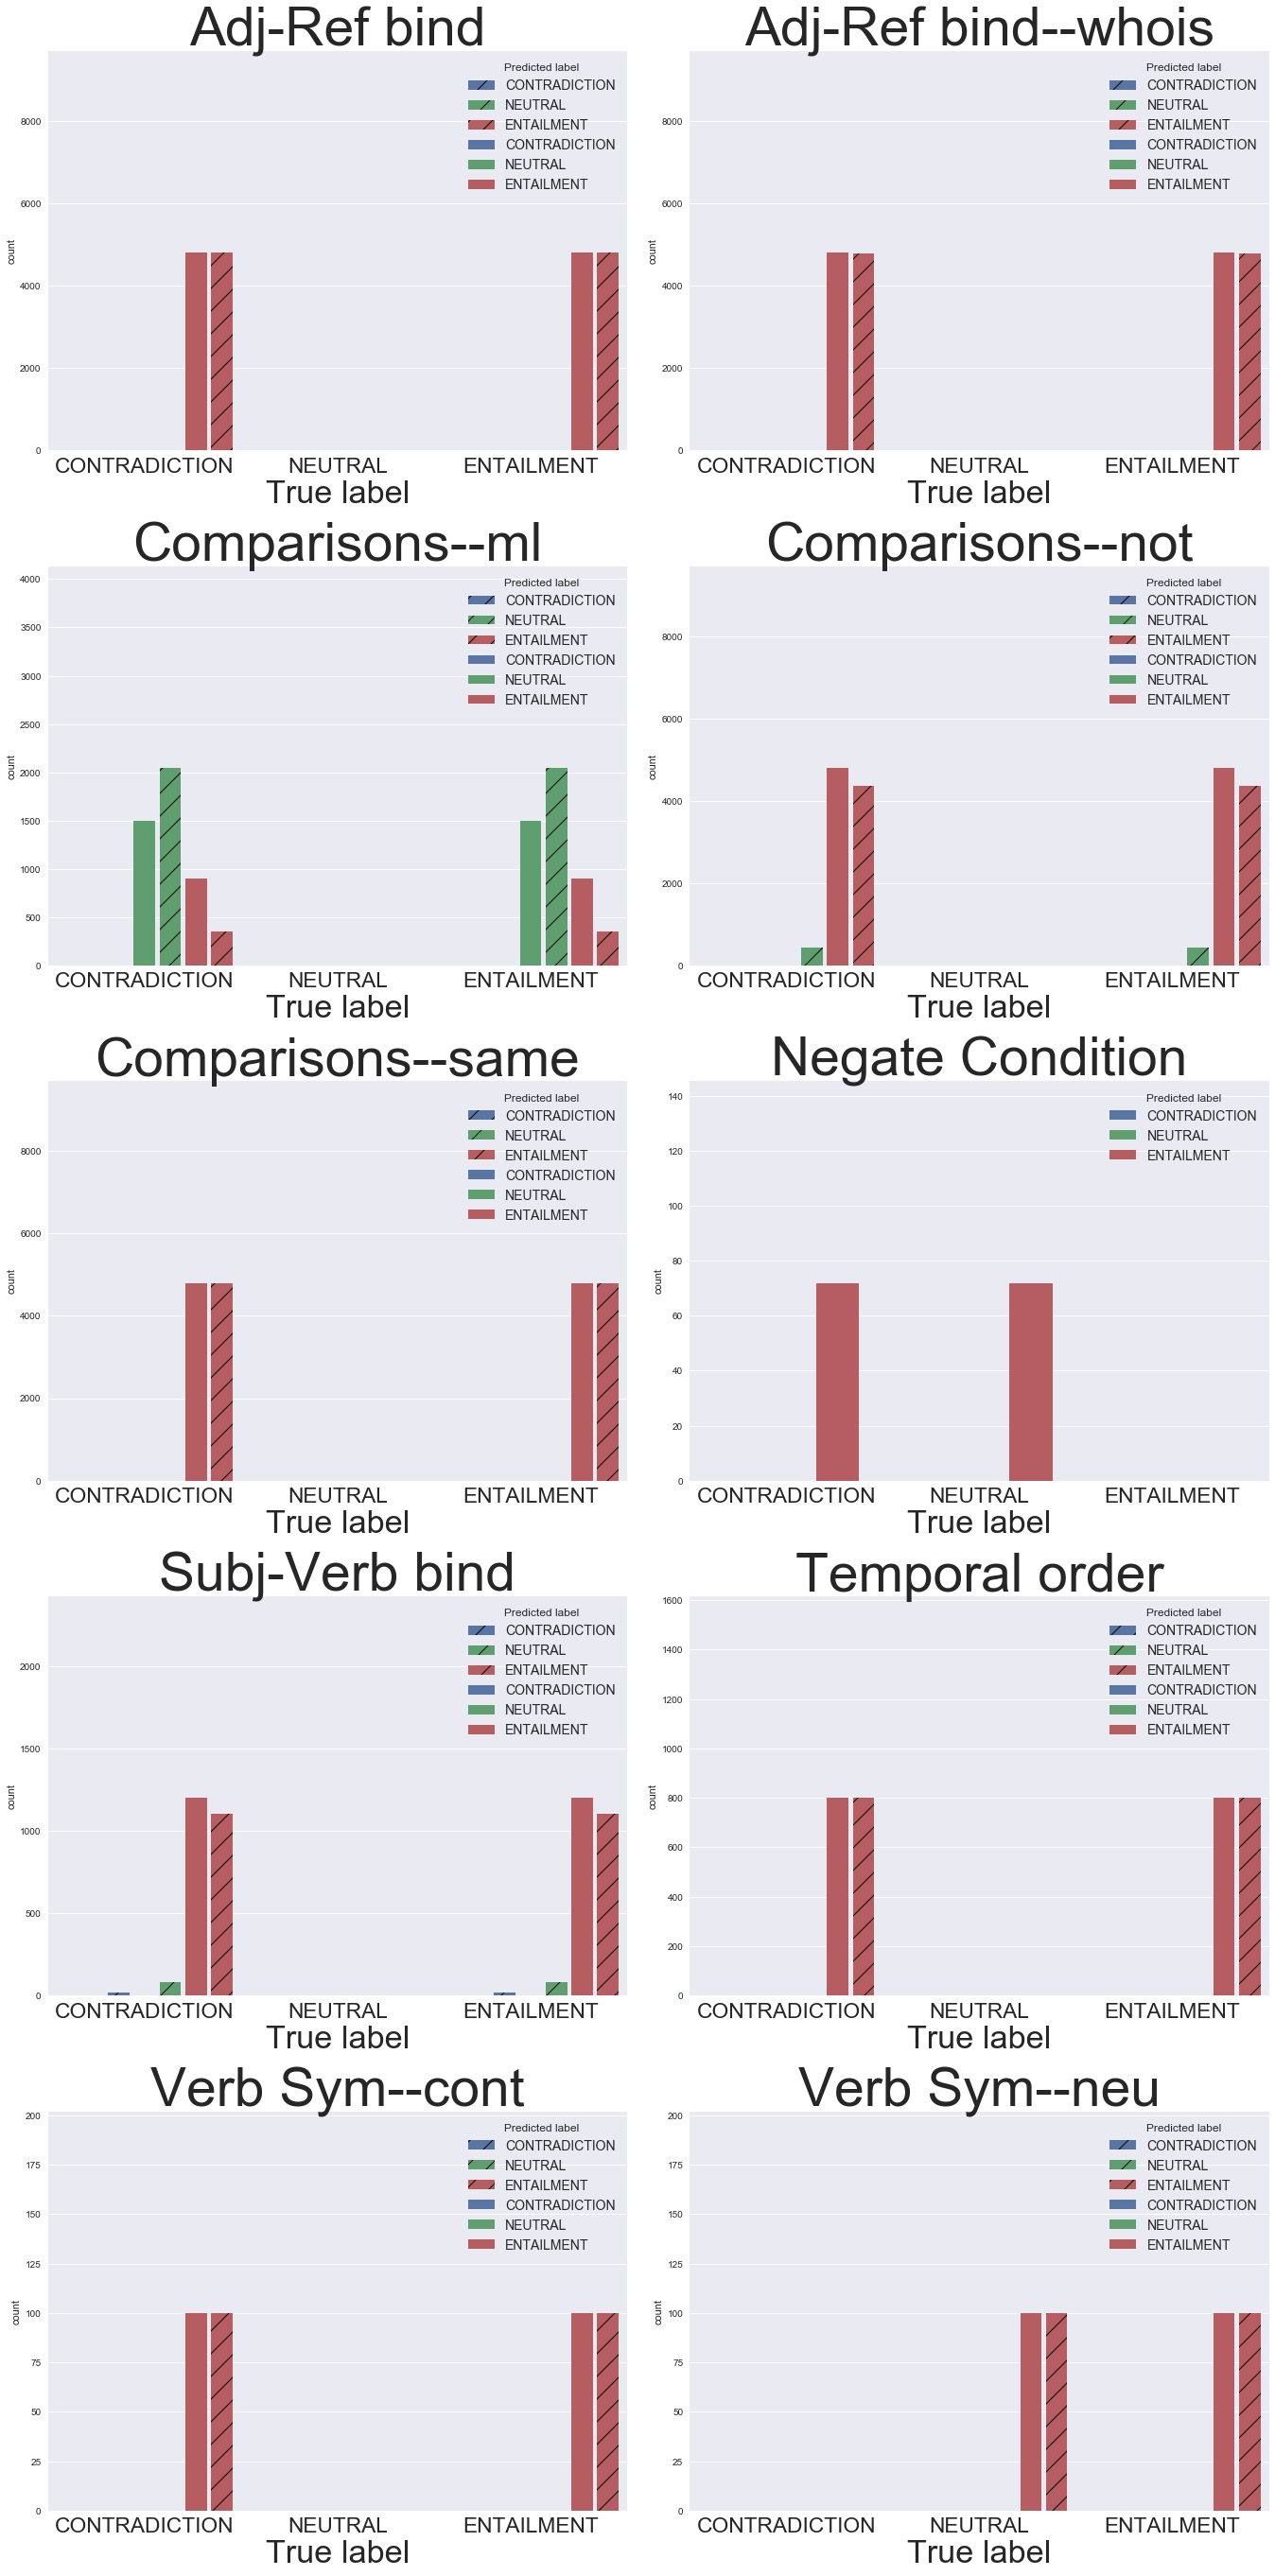

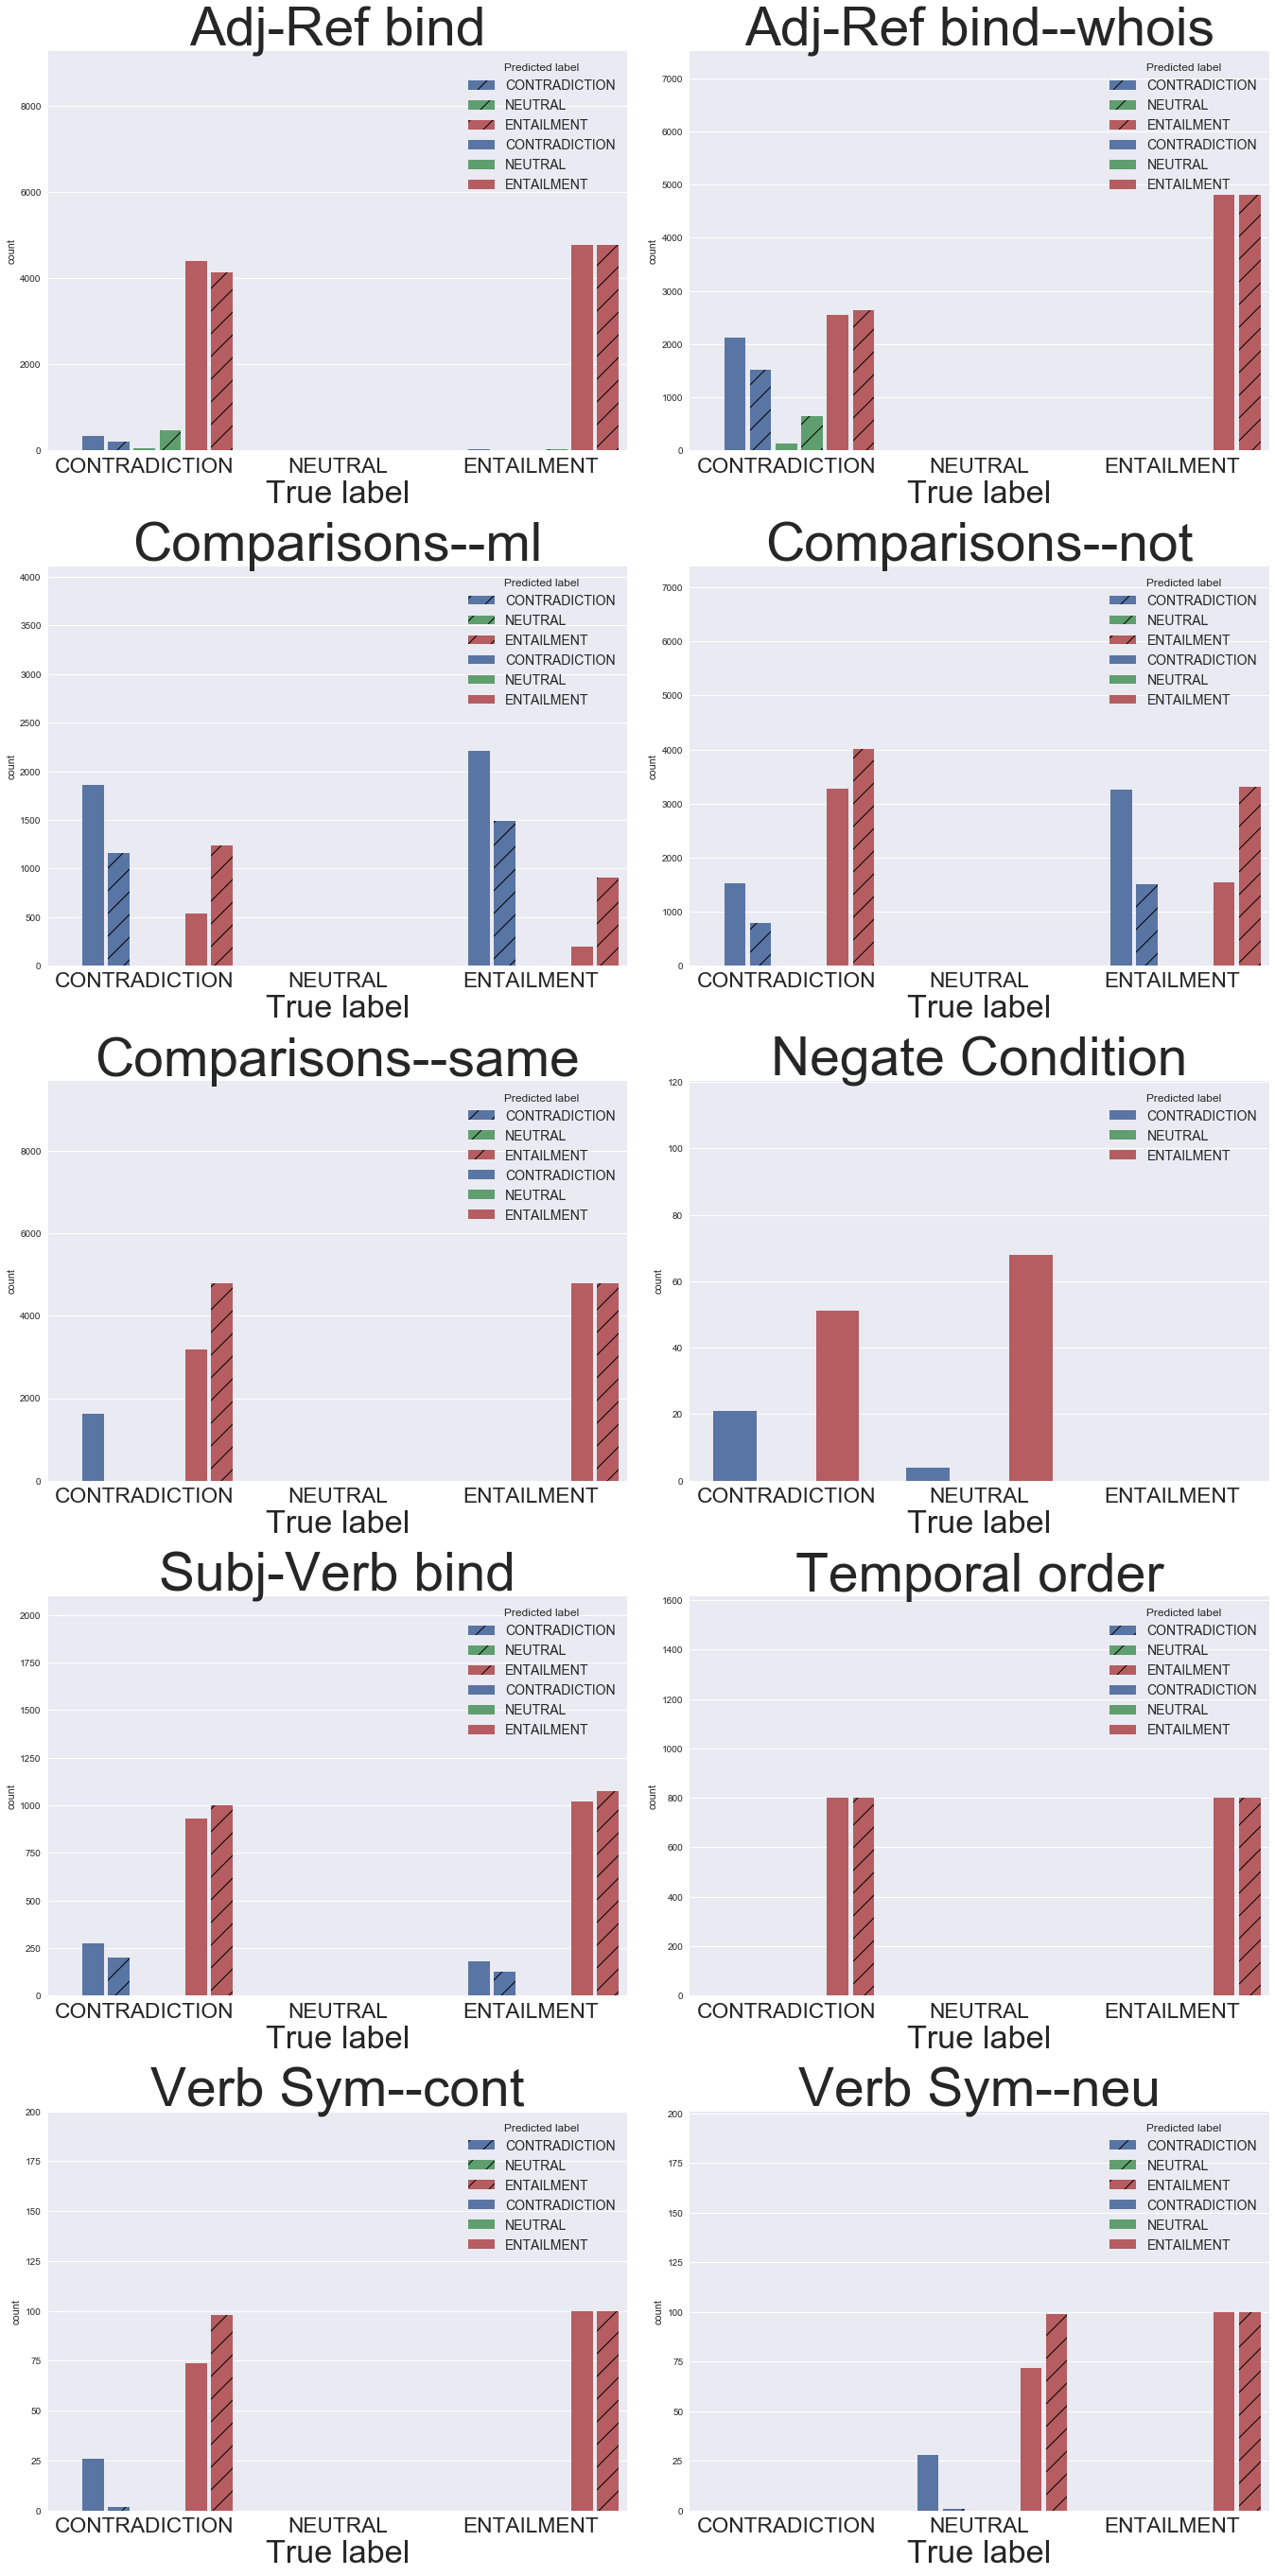

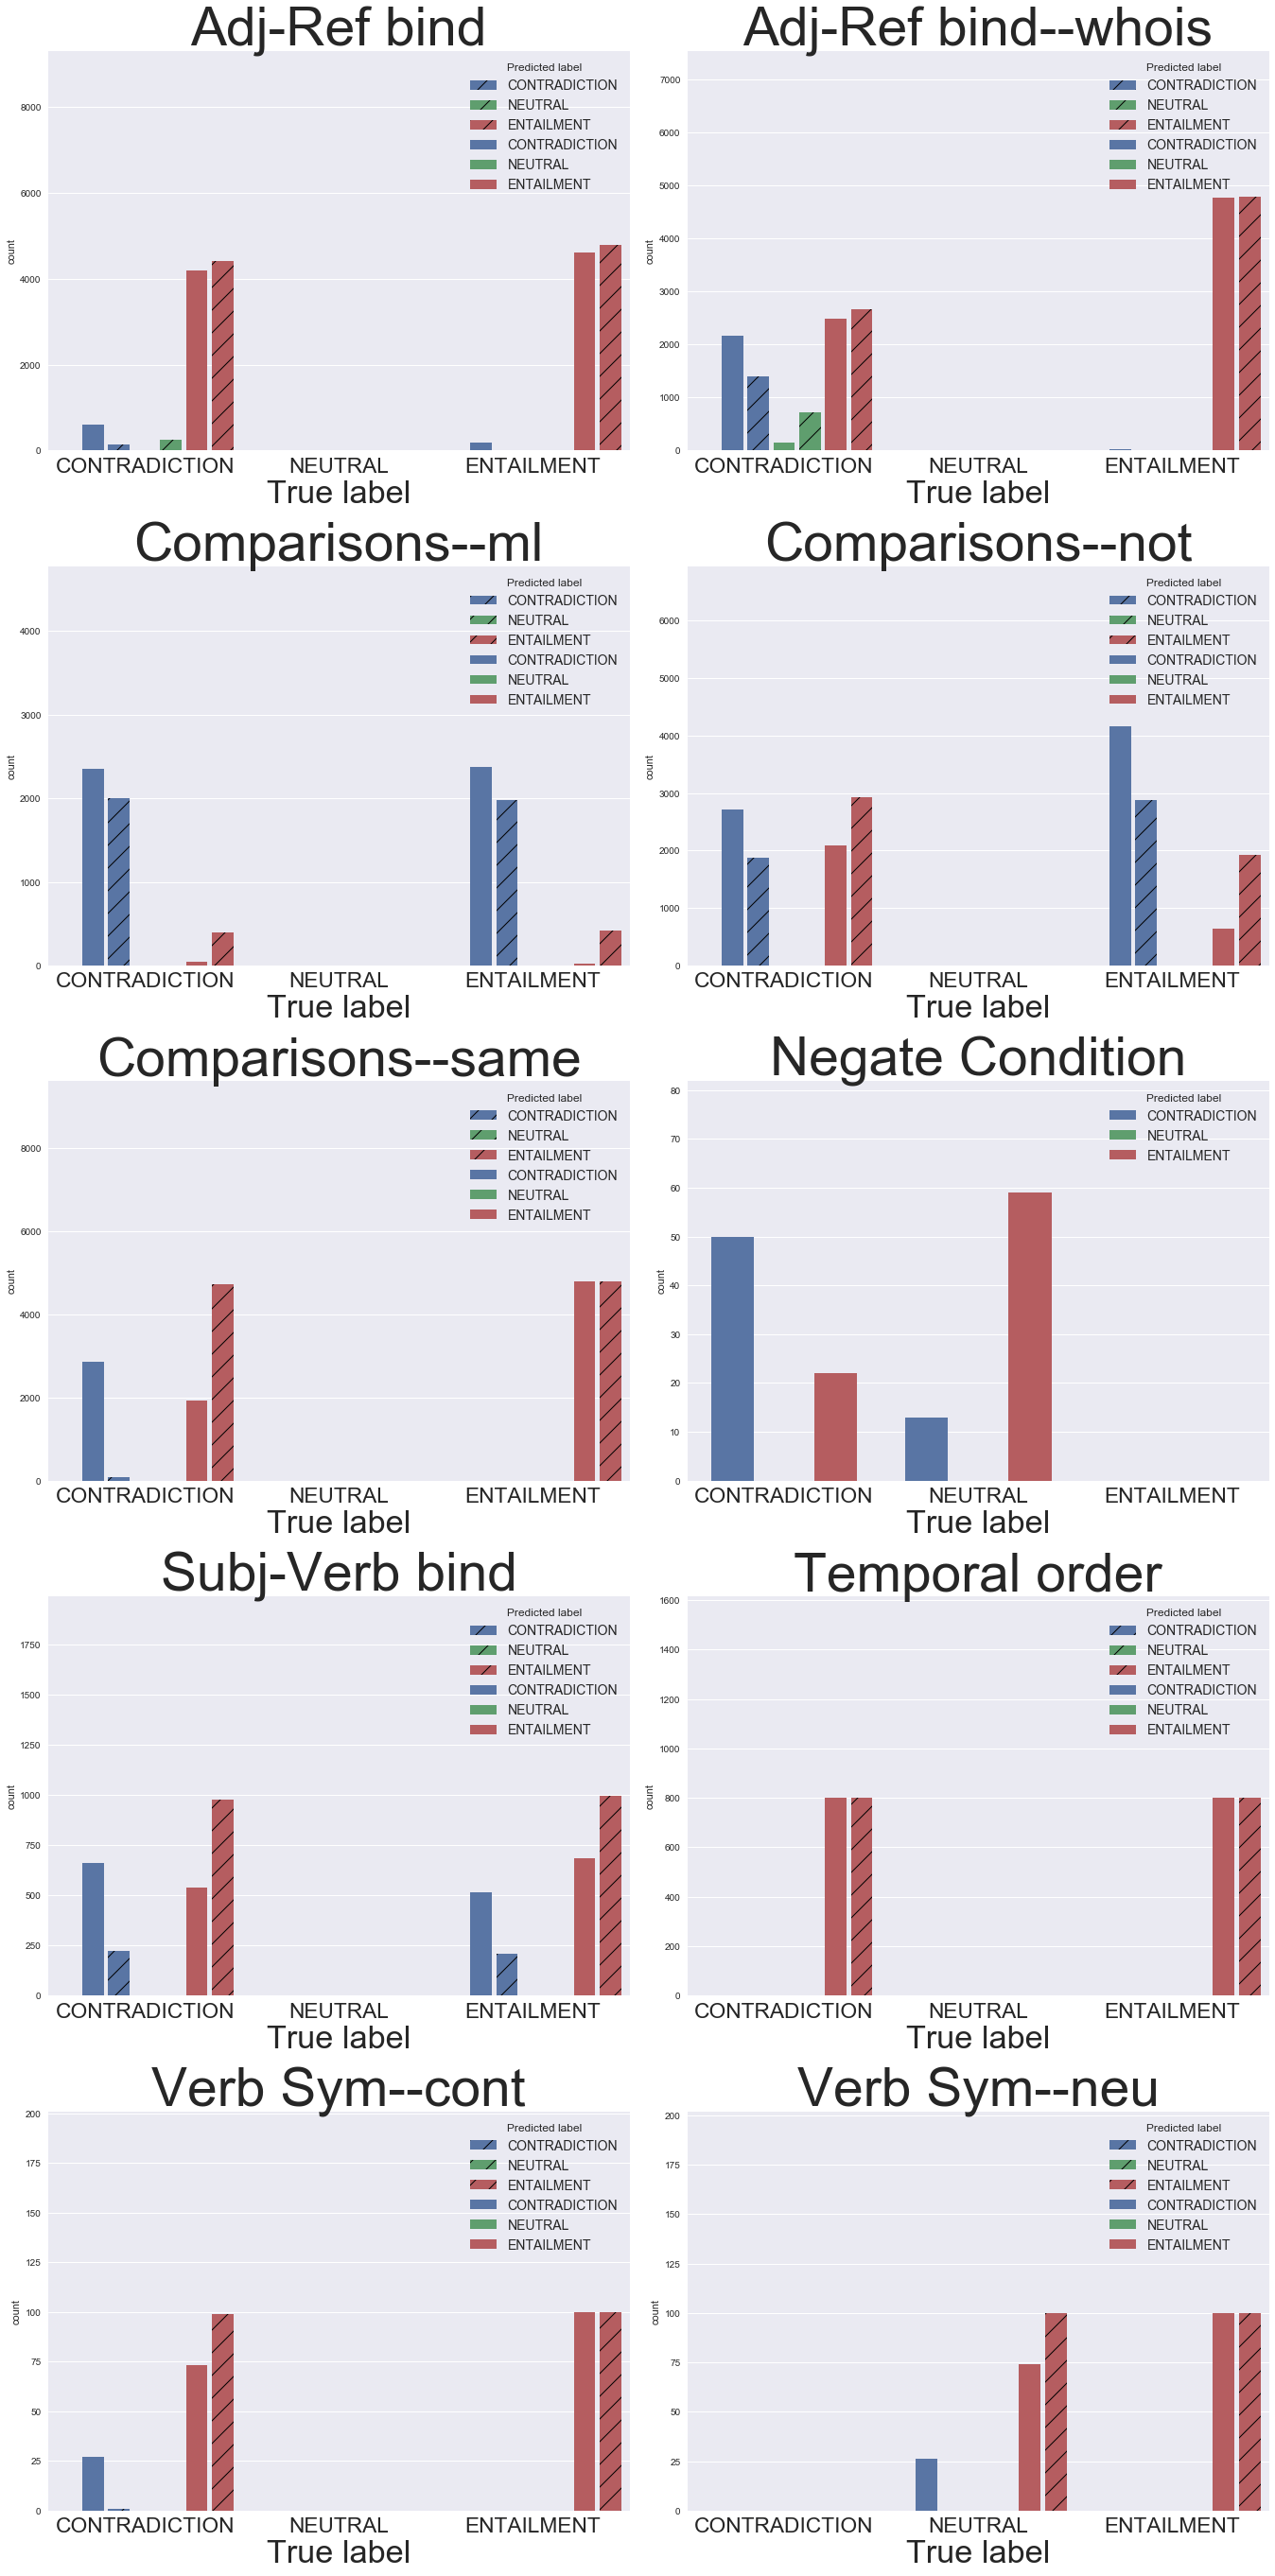

In [20]:
#create figure for histogram split across task and label


for model in models:
    count = 0
    fig = plt.figure(figsize=(10*sc,20*sc))
    for i, task in enumerate(tasks):

        if "_long" not in task: 
            count += 1
            ax = fig.add_subplot(5,2,count)

            
            ax = sns.countplot(
                x="true",
                hue="est",
                order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
                hue_order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
                data=all_results[model][task.replace("_short", "_long")],
                alpha = 1.0)
            
            if "_short" in task:
                for bar in ax.patches:
                    bar.set_hatch('/')
                    x = bar.get_x()
                    width = bar.get_width()
                    bar.set_x(x + width/2.0)
                    
                ax = sns.countplot(
                    x="true",
                    hue="est",
                    order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
                    hue_order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
                    data=all_results[model][task],
                    alpha = 1.0)
                
                for bar in ax.patches:
                    x = bar.get_x()
                    width = bar.get_width()
                    centre = x+width/2.
                    newwidth = width/2.4
                    bar.set_x(centre-newwidth/2.)
                    bar.set_width(newwidth)
    
            else:
                for bar in ax.patches:
                    x = bar.get_x()
                    width = bar.get_width()
                    centre = x+width/2.
                    newwidth = width/1.2
                    bar.set_x(centre-newwidth/2.)
                    bar.set_width(newwidth)
                    
            legend = plt.legend(loc='upper right', fontsize = 14, title = "Predicted label")
            legend.get_title().set_fontsize('12') #legend 'Title' fontsize
#             ax.legend_.remove()
            name = map_name[task].replace('--short', '')
            if "Comp" not in name:
                name = name.replace('--same', '')
            else:
                name = name.replace('--same--not', '--same')
            ax.set_title(name, fontsize = 30*sc)
            
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(12*sc) 
       
            lim = max(np.concatenate((np.bincount([label2id[x.strip()] for x in all_results[model][task]['est']]), 
                                      np.bincount([label2id[x.strip()] for x in all_results[model][task]['true']]),
                                      np.bincount([label2id[x.strip()] for x in all_results[model][task.replace("_short", "_long")]['est']]), 
                                      np.bincount([label2id[x.strip()] for x in all_results[model][task.replace("_short", "_long")]['est']]), 
                                 )))*1.01
            ax.set_ylim([0,lim])
            ax.set_xlabel("True label", fontsize = 18*sc)
    
    plt.tight_layout()
    plt.savefig(outpaths['FIG_PATH'] + 'AllHists' + model)
    

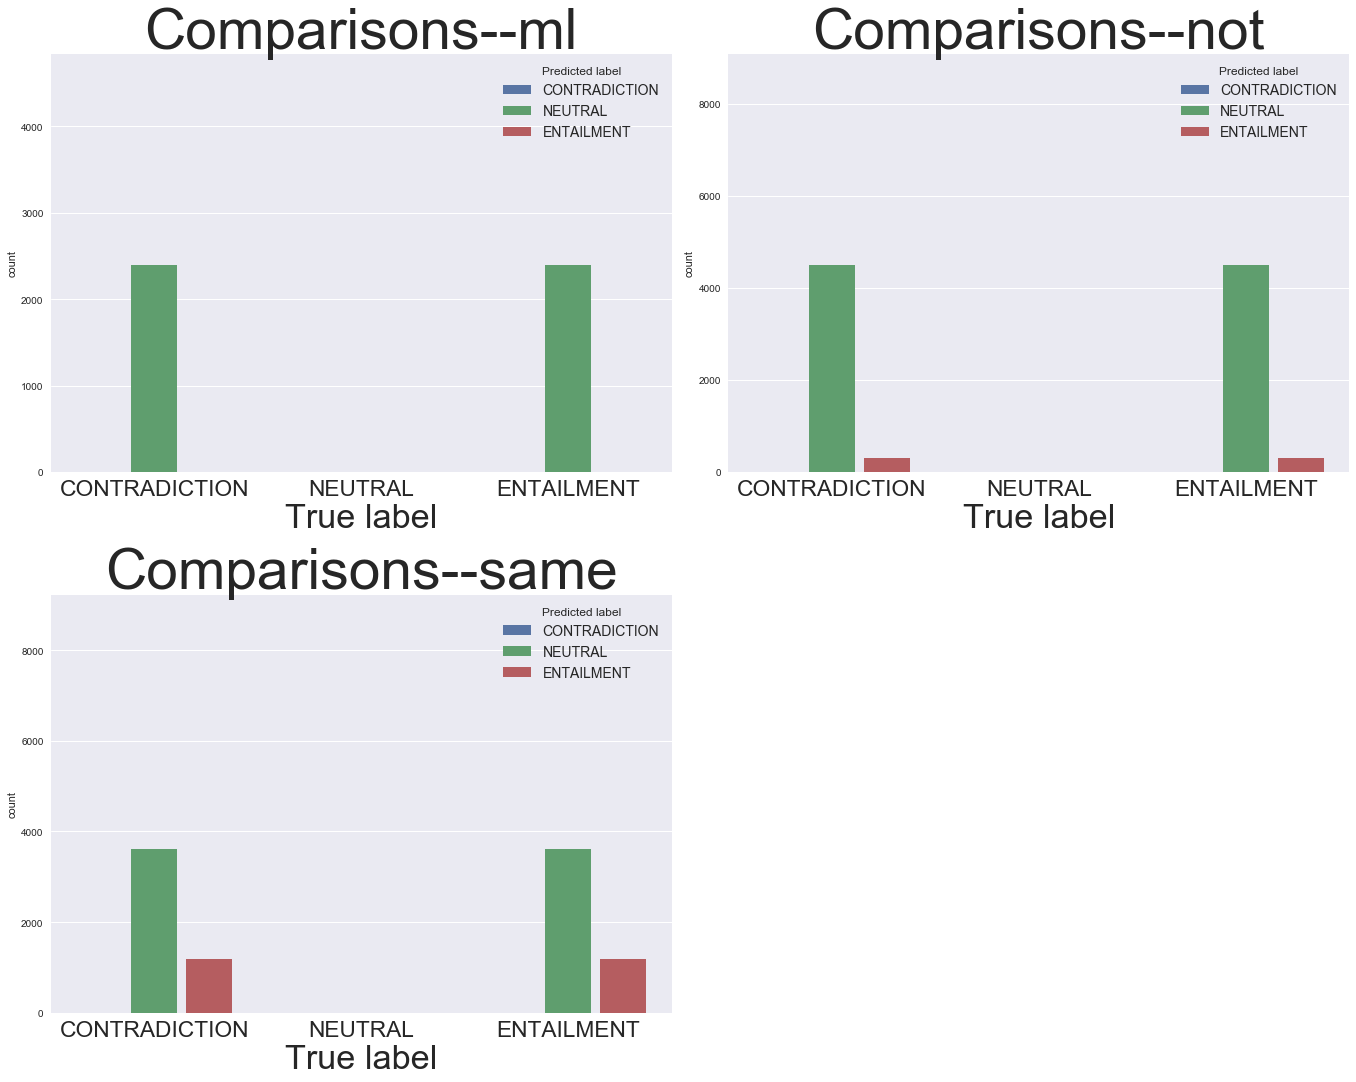

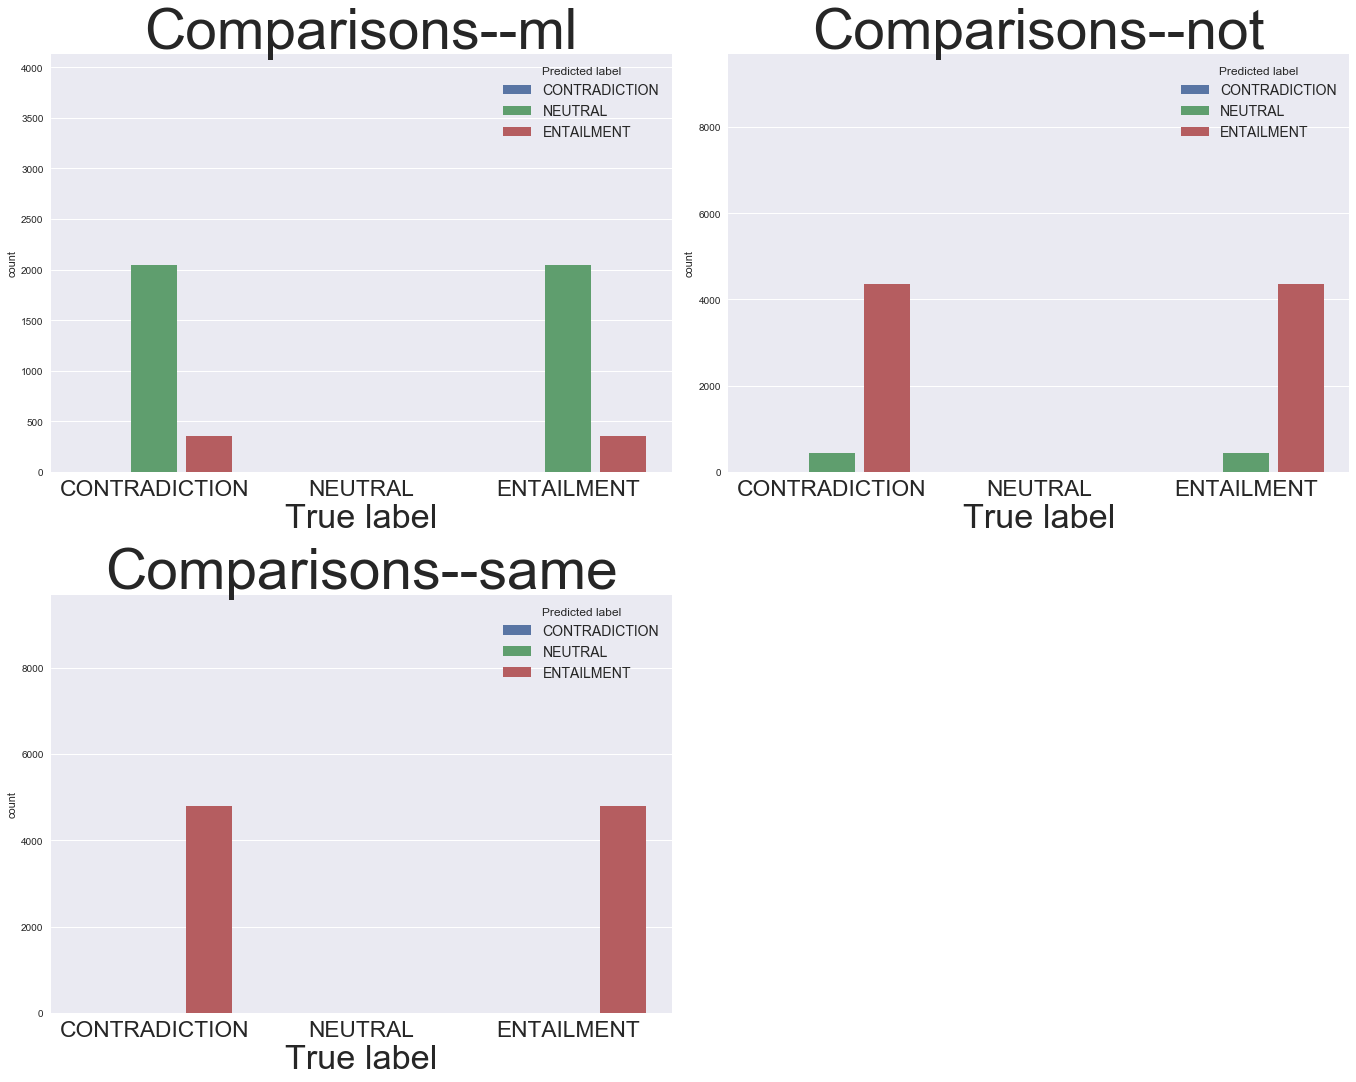

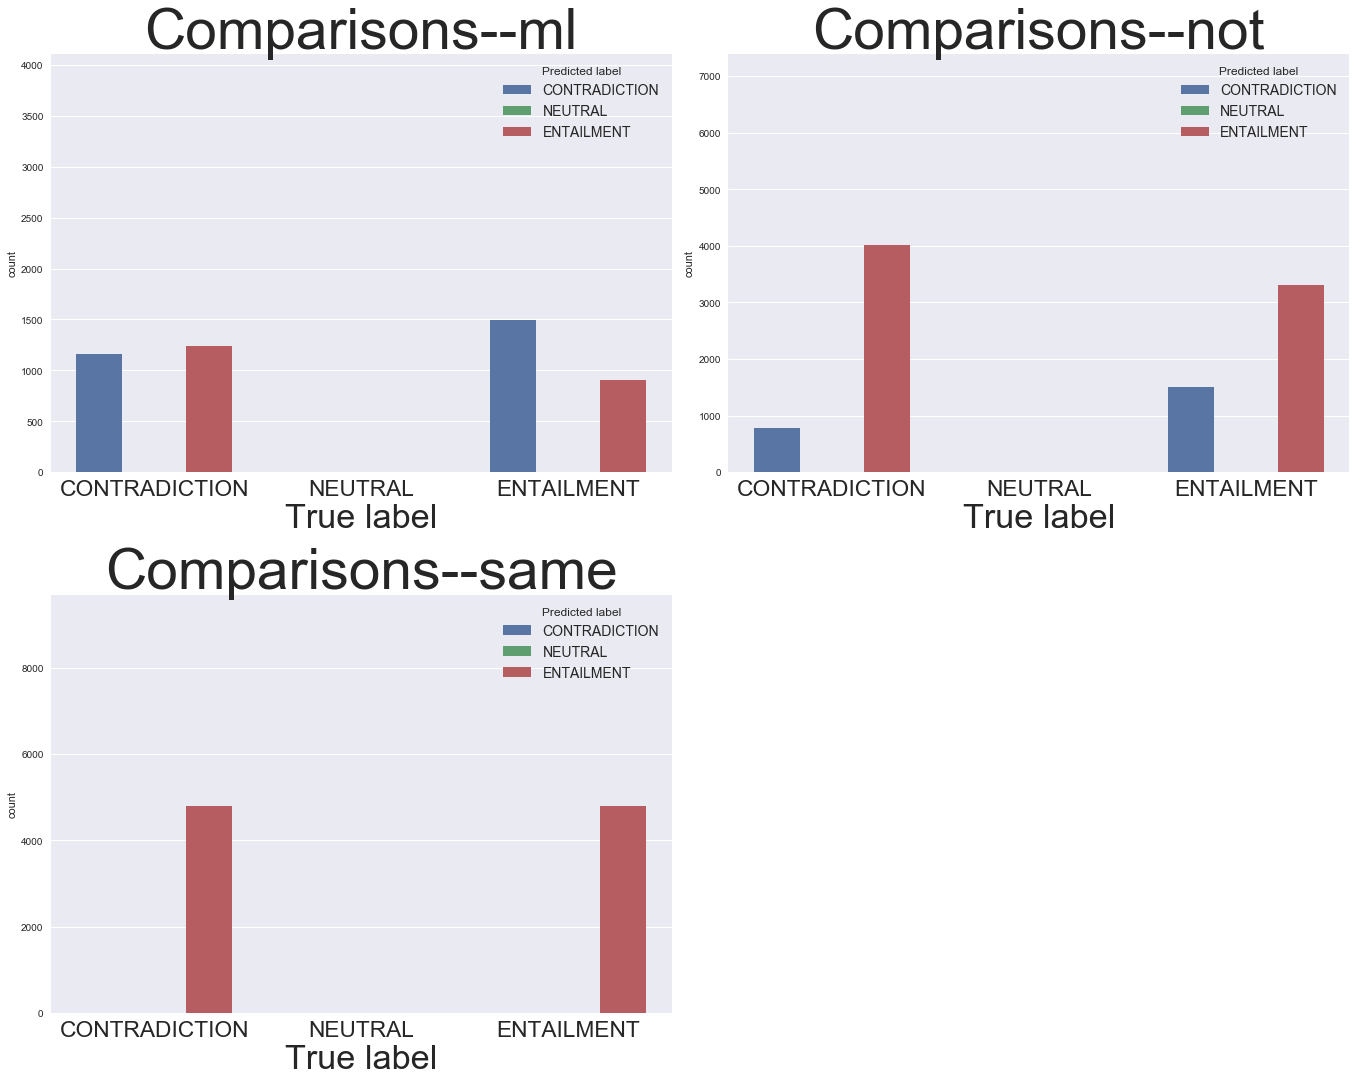

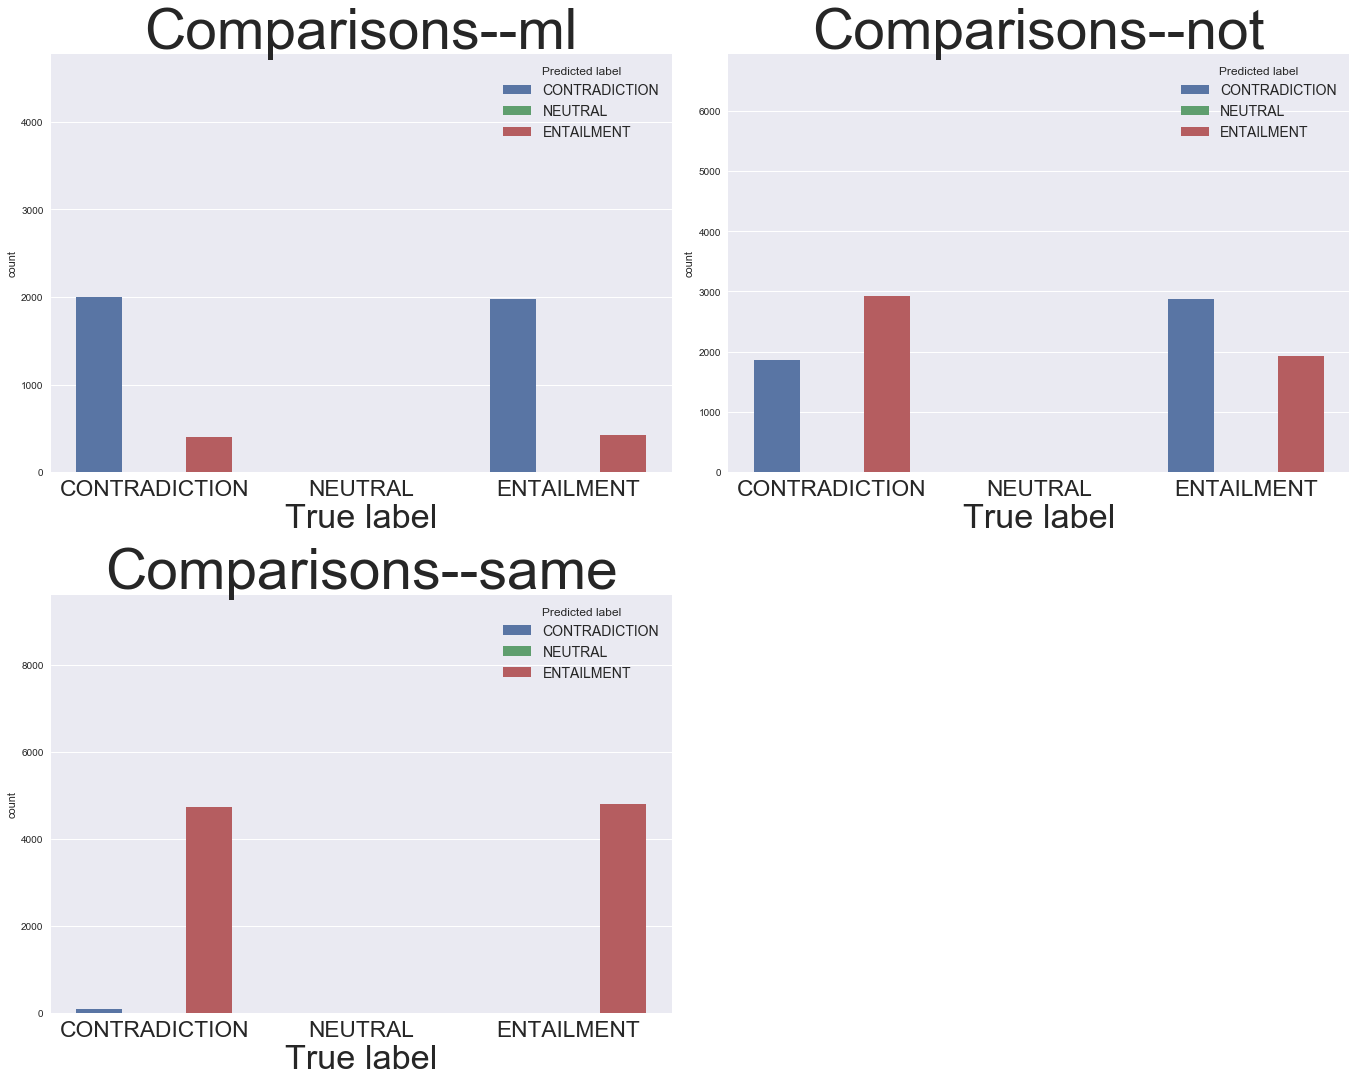

In [30]:
#create figure for histogram split across task and label


for model in models:
    count = 0
    fig = plt.figure(figsize=(10*sc,8*sc))
    for i, task in enumerate(tasks):

        if "comp" in task and "long" not in task:
            count += 1
            ax = fig.add_subplot(2,2,count)

            
            ax = sns.countplot(
                x="true",
                hue="est",
                order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
                hue_order=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"],
                data=all_results[model][task.replace("_short", "_long")],
                alpha = 1.0)
            
            
            for bar in ax.patches:
                x = bar.get_x()
                width = bar.get_width()
                centre = x+width/2.
                newwidth = width/1.2
                bar.set_x(centre-newwidth/2.)
                bar.set_width(newwidth)
                    
            legend = plt.legend(loc='upper right', fontsize = 14, title = "Predicted label")
            legend.get_title().set_fontsize('12') #legend 'Title' fontsize
#             ax.legend_.remove()
            name = map_name[task].replace('--short', '')
            if "Comp" not in name:
                name = name.replace('--same', '')
            else:
                name = name.replace('--same--not', '--same')
            ax.set_title(name, fontsize = 30*sc)
            
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(12*sc) 
       
            lim = max(np.concatenate((np.bincount([label2id[x.strip()] for x in all_results[model][task]['est']]), 
                                      np.bincount([label2id[x.strip()] for x in all_results[model][task]['true']]),
                                      np.bincount([label2id[x.strip()] for x in all_results[model][task.replace("_short", "_long")]['est']]), 
                                      np.bincount([label2id[x.strip()] for x in all_results[model][task.replace("_short", "_long")]['est']]), 
                                 )))*1.01
            ax.set_ylim([0,lim])
            ax.set_xlabel("True label", fontsize = 18*sc)
    
    plt.tight_layout()
    plt.savefig(outpaths['FIG_PATH'] + 'AllHists' + model)
    